In [1]:
import cameratransform as ct
import pandas as pd
import os
import numpy as np
import rasterio
from PIL import Image
import matplotlib.pyplot as plt
import glob
import micasense.imageset
import micasense.capture
import micasense.imageutils
import cv2
import algorithms.select_GPS as SelectGPS
import importlib
import algorithms.flight_attributes
importlib.reload(algorithms.flight_attributes)
import algorithms.flight_attributes as FlightAttributes
import algorithms.georeferencing as georeferencing

# README

This python notebook shows different direct-georeferencing techniques - [MosaicSeadron](https://github.com/SeadroneICMAN/MosaicSeadron) and the one proposed in this study.

**Sensor used**: MicaSense's 10-Band Dual Camera System

![MicaSense's Dual Camera System](plots/camera%20parameters.png)

## Folder organisation
Check whether the following folders and data are present after running `preprocessing.ipynb`. See instructions in `preprocessing.ipynb`
- **flight folder** (a folder that contains all the images captured from a flight, as well as meta data, and processed data used the micasense's image processing library).
- **flight_attributes** (a folder that contains the metadata of each capture from the flight).
    - *flight_attributes.csv* a csv file that is automatically generated from the modified micasense preprocessing library
    - *gps_index.txt* a text file that contains the selected gps points selected from the GUI in `algorithms/select_GPS.py`. Run `algorithms/select_GPS.py` to interactively select the start and end points of the flight swaths.
- **RawImg** (a folder that contains all the band images captured from a flight e.g. *IMG_0000_1.tif* to *IMG_xxxx_10.tif*. One can easily create a folder named "RawImg" and shift all the raw images here).
    - *IMG* is the prefix for all image captures
    - *_0000* is the index of the image (each capture should have a unique index)
    - *_1* is the band number of the capture, e.g. for a 10-band image, the band number will range from 1 - 10. So each capture will have 10 images e.g. *IMG_0000_1* to *IMG_0000_10*.
- **stacks** (a folder that contains the processed band images, where band images are all band-aligned to create a multispectral image). e.g. the postfix (as a default) always ends with *_1*, but all images in the stacks folder should have a unique image index.
- **thumbnails** (a folder that contains the thumbnail rgb of each capture, which allows for fast plotting of rgb orthomosaics)
```
flight folder (imagePath)
|
│
└───flight_attributes
│   │   flight_attributes.csv
│   │   gps_index.txt
│   
└───RawImg
|   │   IMG_0000_1.tif
|   │   IMG_0000_2.tif
|   |   ...
└───stacks
|   │   IMG_0000_1.tif
|   │   IMG_0001_1.tif
|   |   ...
└───thumbnails
    │   IMG_0000_1.jpg
    │   IMG_0001_1.jpg
    |   ...
```

# Define folders

In [2]:
imagePath = r"D:\EPMC_flight\pandanRes\00angle_15H_80overlap" # equivalent to the flight folder
if os.path.exists(os.path.join(imagePath,'thumbnails')):
    parent_dir = os.path.join(imagePath,'thumbnails')
    fp_list = [os.path.join(parent_dir,fp) for fp in sorted(os.listdir(parent_dir))]

else:
    fp_list = None

rawImagePath = os.path.join(imagePath,'RawImg') # We created a new folder called RawImg to store all the raw images here

# import metadata csv
log = pd.read_csv(os.path.join(imagePath, 'flight_attributes', 'flight_attributes.csv')) # The log.csv contains geoinformation of the captures
# import GPS points
flight_points = SelectGPS.readSelectedGPS(rawImagePath)
# import altitude info
height_dict = FlightAttributes.get_heights(imagePath,log)

[22, 41, 45, 64, 68, 88, 92, 111, 115, 134, 138, 157, 161, 180, 184, 203, 207, 226, 230, 249, 253, 272, 277, 295, 300, 318, 323, 341, 346, 365, 369, 388]
offset height: 21m


## import GPS points

The GPS points must have already been selected and saved in `flight_attributes/gps_index.txt`. See the instructions in `preprocessing.ipynb`.

[22, 41, 45, 64, 68, 88, 92, 111, 115, 134, 138, 157, 161, 180, 184, 203, 207, 226, 230, 249, 253, 272, 277, 295, 300, 318, 323, 341, 346, 365, 369, 388]


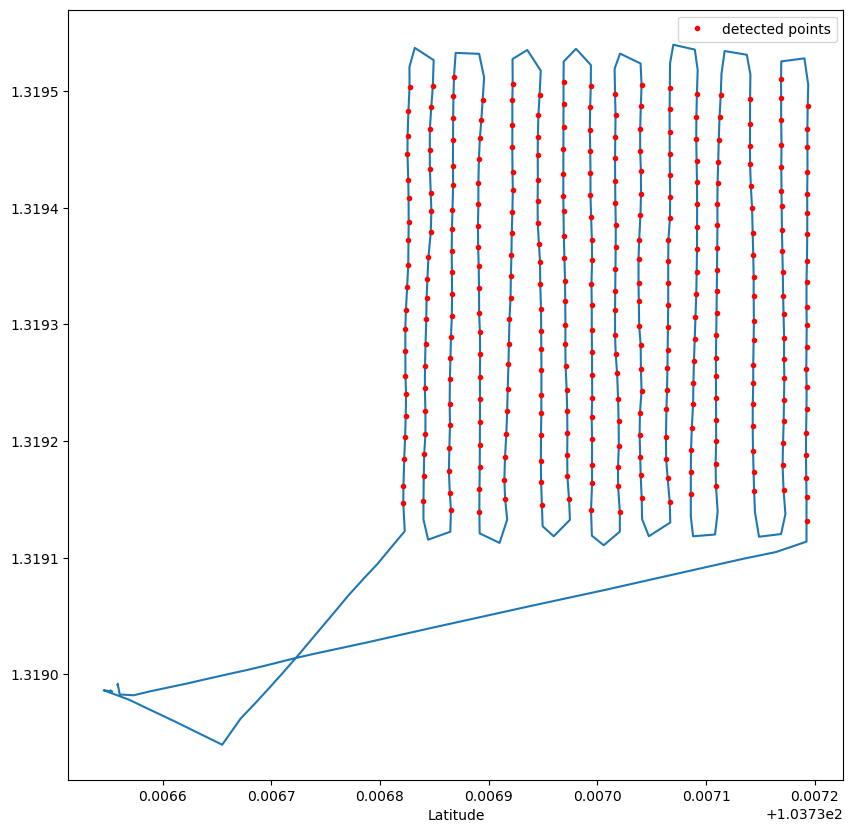

[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265

In [3]:
ls_idx = SelectGPS.readSelectedGPS(rawImagePath)
DL = SelectGPS.DetectLines(log, n = 3, thresh=0.99, plot=True)
flight_points = DL.get_points(flight_points = ls_idx)
print(flight_points)

# Mosaic Seadron direct georeferencing

In [8]:

def modify_df(df_cropped, DEM_offset_height):
    #----------------append flight angle---------------------------------------------
    df_cropped.loc[:,['flight_angle']] = -df_cropped['dls-yaw']/np.pi*180
    # ---- instead of using yaw, use the heading of the UAV----------
    reclassify_angles = lambda x: -180 if x < -160 else 0
    reclassified_angles = [reclassify_angles(i) for i in df_cropped['flight_angle'].to_list()]
    df_cropped.loc[:,['flight_angle']] = reclassified_angles
    #-----------adjust UAV's altitude instead of using GPS's altitude reading--------
    df_cropped.loc[:,['altitude']] = df_cropped.loc[:,['altitude']] - DEM_offset_height
    return df_cropped

df_cropped = modify_df(log, DEM_offset_height = height_dict['DEM_offset_height'])
df_cropped = df_cropped.iloc[flight_points,:]

for image_index, rows in df_cropped.iterrows():
    image_name = rows['image_name']
    flight_angle = rows['flight_angle']
    
    # georeference each UAV image
    RG = georeferencing.MosaicSeadron(rows['latitude'],
                                        rows['longitude'],
                                        rows['altitude'],
                                        flight_angle = flight_angle)
    RG.georeference(imagePath, image_name, "UAVHeadingMosaicSeadron_alt40")

c:\Users\PAKHUIYING\anaconda3\envs\micasenseGeoreferencing\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


# Direct georeferencing (this study)

Do note that this is just direct georeferencing without any image alignment applied to it yet. Refer to `alignmentError.ipynb`

In [12]:
def modify_df(df_cropped, DEM_offset_height):
    #----------------append flight angle---------------------------------------------
    df_cropped.loc[:,['flight_angle']] = -df_cropped['dls-yaw']/np.pi*180
    # ---- instead of using yaw, use the heading of the UAV----------
    reclassify_angles = lambda x: -180 if x < -160 else 0
    reclassified_angles = [reclassify_angles(i) for i in df_cropped['flight_angle'].to_list()]
    df_cropped.loc[:,['flight_angle']] = reclassified_angles
    #-----------adjust UAV's altitude instead of using GPS's altitude reading--------
    df_cropped.loc[:,['altitude']] = df_cropped.loc[:,['altitude']] - DEM_offset_height
    return df_cropped

df_cropped = log.iloc[flight_points,:]
df_cropped = modify_df(df_cropped, height_dict['DEM_offset_height'])
for image_index in flight_points:
    lat = df_cropped['latitude'][image_index]
    lon = df_cropped['longitude'][image_index]
    alt = df_cropped['altitude'][image_index]
    image_name = df_cropped['image_name'][image_index]
    flight_angle = df_cropped['flight_angle'][image_index]
    georeferencing.directGeoreferencing_gdal(imagePath,image_name,lat,lon,alt,flight_angle, 
                                             dirname="UAVHeadingCoordShift_alt20")